In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import *

## Decode probability

In [2]:
## without interference, d0

def get_d0(r, r0, k):
    return 1 - (r/r0)**k

## with ATCRBS interference, dA, x number of FRUIT
def get_dA(r, r0, x):
    k = [3.94, 3.37, 3.23, 2.75, 2.66]
    
    return 1 - (r/r0)**(k[x-1])

## with one Mode S interference overlap, dS
def get_dS(r, r0prime, k):
    return 1 - (r/r0prime)**k

## Secondary aircraft message interference

In [3]:
def get_p_x_mA(x, r, rho, N_atcrbs):
    tau_identify = 20.3e-6
    tau_altitude = 20.3e-6
    
    nb_ac = rho*r
    
#     mA = λ_A/C τ_A/C + λC_TCAS τC_TCAS
#     λ_A/C = N * b * PRF * M
#     λ_A/C = N_ATCRBS * 1.65 * (M_AC + M_S)
    
    prf = 1.65
    
    mA = nb_ac * (prf * N_atcrbs * tau_identify + prf * N_atcrbs * tau_altitude)
    
    p_x_mA = mA**x/(factorial(x)) * e**(-mA)
    
    return p_x_mA

def get_p_x_mS(x, r, rho, N_tcas_s, N_mode_s):
    tau_short = 64e-6
    tau_long = 120e-6
    
    nb_ac = rho*r
#     print(nb_ac)
        
    lb_0 = N_tcas_s * nb_ac
    lb_4 = N_mode_s * 1/3 * (nb_ac)
    lb_11 = N_mode_s * 1/6 * (nb_ac)
    lb_17 = 6.2 * (nb_ac)
    
    mS = lb_0 * tau_short + lb_4 * tau_short + lb_11 * tau_short + lb_17 * tau_long
    
    p_1_mS = mS**x/factorial(x) * e**(-mS)
    
    return p_1_mS

## Final calculation

In [4]:
def get_prob_chung(r, rho, params, r0 = 96.6, r0prime = 30, k = 6.4314):

    N_atcrbs, N_tcas_s, N_mode_s = params

    d0 = get_d0(r, r0, k)

    dA = 0
    
    for x in range(1, 6):
        dA += get_dA(r, r0, x)

    dS = get_dS(r0prime, r0, k)

    p_0_mA = get_p_x_mA(0, r, rho, N_atcrbs)
    p_0_mS = get_p_x_mS(0, r, rho, N_tcas_s, N_mode_s)
    p_1_mS = get_p_x_mS(1, r, rho, N_tcas_s, N_mode_s)

    # print(p_0_mA, p_0_mS, p_x_mA, p_1_mS)

    first_term_1 = 0
    for x in range(1,6):
        first_term_1 += get_dA(r, r0, x) * get_p_x_mA(x, r, rho, N_atcrbs)

#     print(d0, p_0_mA, p_0_mS)
    
    term1 = d0 * p_0_mA * p_0_mS
    term2 = first_term_1 * p_0_mS
    term3 = dS * p_1_mS * p_0_mA
    term4 = first_term_1 * p_1_mS * dS
    
    return term1 + term2 + term3 + term4, term1

In [5]:
import pandas as pd

df_datasize = pd.read_csv('../results/1433801924/nb_data.csv')
df_prob = pd.read_csv('../results/1433801924/probability_first_bump.csv')

df_datasize.drop(df_datasize.columns[0],axis=1,inplace = True)
df_prob.drop(df_prob.columns[0],axis=1, inplace = True)

range_arr = np.array(range(0, 250, 10))

4
8
10
14


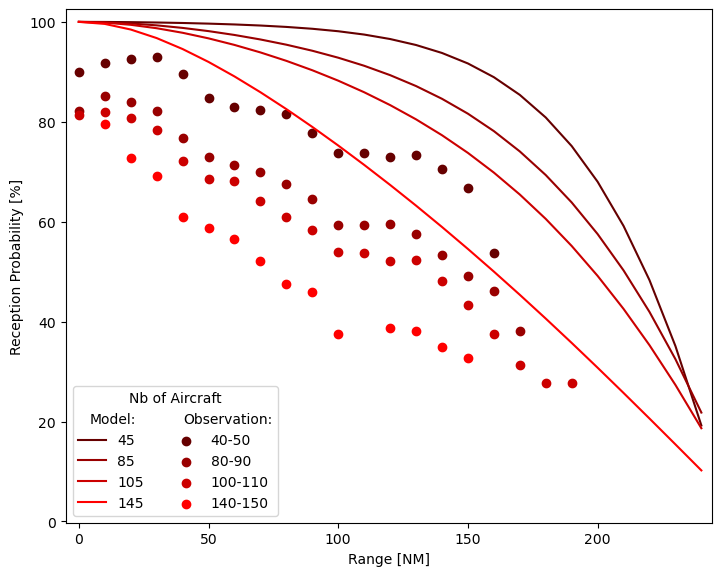

In [6]:
plt.figure(figsize=(10/1.2, 8/1.2))

red_shades = ['#FF0000', '#CC0000', '#990000', '#660000']


colors = red_shades[::-1]

counter = 0

traf_list = [4, 8, 10, 14]

for traf in traf_list:
    traf = traf * 10 + 5
    r0 = 239
    rho = traf/(r0)
    
    k = 6.4314
    
    prob = []
    prob1 = []
    
    N_atcrbs = 83
    M_atcrbs_per_mode_s = 2 ## Number of ATCRBS equipped/Number of Mode S eq : 2:1 (estimated from Figure 5)
    N_mode_s = N_atcrbs * M_atcrbs_per_mode_s
    N_tcas_s = traf

    params = N_atcrbs, N_tcas_s, N_mode_s

    r0prime = 83.18945509395692
    
    r_list = range(0, r0 + 10, 10)
    for r in r_list:
        p, p1 = get_prob_chung(r, rho, params, r0)
        prob.append(p)
        prob1.append(p1)
        
    prob = np.array(prob)*100
    prob1 = np.array(prob1)*100
        
    plt.plot(list(r_list), prob, label = '{}'.format(traf), color = colors[counter])
#     plt.plot(list(r_list), prob1, label = '{}'.format(traf), color = colors[counter])
    
    counter += 1
    
plt.legend(title = 'Nb Aircraft')
plt.ylim(-0.25, 102.5)
plt.xlabel('Range [NM]')
plt.ylabel('Reception Probability [%]')

# Filter df_nb based on the condition df_nb < 2000
filtered_nb = df_datasize[df_datasize > 2500]

# Create a mask where the filtered values are True and others are False
mask = filtered_nb.notnull()

# print(mask)
# Plot each row of df_prob after applying the mask
counter = 0

for i, row in df_prob.iterrows():
#     print(row[mask.iloc[i]])
    if(i in traf_list):
        print(i)
        plt.scatter(range_arr[mask.iloc[i]], row[mask.iloc[i]], label='{}-{}'.format(i*10, (i+1)*10), color = colors[counter])
        counter += 1

plt.xlabel('Range [NM]')
plt.ylabel('Reception Probability [%]')
# plt.title('Rows of df_prob with df_nb < 2000')

ax = plt.gca()
h, l = ax.get_legend_handles_labels()
ph = [plt.plot([],marker="", ls="")[0]]*2
handles = ph + h

nb_handle = len(traf_list)

handles = ph[:1] + h[:nb_handle] + ph[1:] + h[nb_handle:]

labels = ["Model:"] + l[:nb_handle] + ["Observation:"] + l[nb_handle:]

leg = plt.legend(handles, labels, ncol=2, title = 'Nb of Aircraft')

# print(labels)

for vpack in leg._legend_handle_box.get_children():
    for hpack in vpack.get_children()[:1]:
        hpack.get_children()[0].set_width(0)

plt.xlim(-5, r0 + 5)
plt.show()